# CAMERA CALIBRATION

In [1]:
# Import all required libraries
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

In [2]:
# image directory
image_dir = os.path.join("..", 'camera_cal')
image_paths = glob.glob(os.path.join(image_dir, 'calibration*.jpg'))

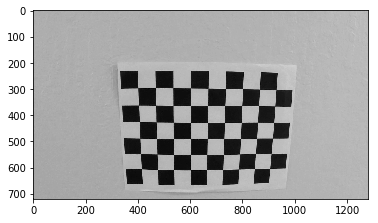

In [3]:
# Lets check image for calibration
test_img_idx = 4
test_img = cv2.imread(image_paths[test_img_idx])
test_gray = cv2.cvtColor(test_img,cv2.COLOR_RGB2GRAY)
plt.imshow(test_gray,cmap= 'gray')

From above image we can see that we need detect 9x6 inner corners on chessboard.

In [4]:
corners_size = 9, 6

With help of `findChessboardCorners()` function we can find corners and in `ret` parameter we will get pattern detected in above image.

In [5]:
ret, corners = cv2.findChessboardCorners(test_gray, corners_size, None)

In [6]:
# First left top corner coordinates
print(np.squeeze(corners[:4]))

[[ 402.62612915  298.50134277]
 [ 468.99658203  298.15881348]
 [ 535.74658203  298.45605469]
 [ 603.02929688  298.81674194]]


In [7]:
# Last bottom right corner coordinates
print(np.squeeze(corners[-4:]))

[[ 725.95983887  608.56890869]
 [ 787.38458252  606.90826416]
 [ 846.76898193  604.99786377]
 [ 906.08453369  603.68896484]]


-> Lets visualize the points using `drawChessboardCorners()`

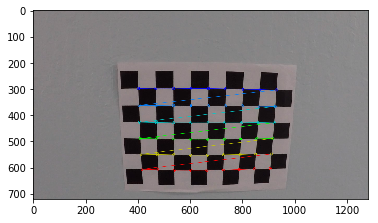

In [8]:
test_img = cv2.drawChessboardCorners(test_img, corners_size, corners, ret)
plt.imshow(test_img);

**Revise**

-> Using mgrid trick to visualize the expected coordinates for undistored

In [9]:
grid = np.mgrid[0:3, 0:3]
grid

array([[[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2]],

       [[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2]]])

Coordinates mapping on matrix array (3,7) to [3, 7]

In [10]:
grid[:,1, 2]

array([1, 2])

In [11]:
grid.shape

(2, 3, 3)

In [12]:
# we will transpose grid because y is changing faster than x
grid.T.shape

(3, 3, 2)

In [13]:
# This serves both the purpose of having the x/y dimension in the last index, 
# as well as sorting the coordinates along the first row, then followed by the second row, etc.
grid.T.reshape(-1, 2)

array([[0, 0],
       [1, 0],
       [2, 0],
       [0, 1],
       [1, 1],
       [2, 1],
       [0, 2],
       [1, 2],
       [2, 2]])

-> Creating list of expected coordinates for inner chessboard corners, considering x,y dimensions in 3D space keeping z as zero. Which implies that chessboard will be static.

In [14]:
# Creating empty list
num_coords = np.prod(corners_size)
objp = np.zeros((num_coords, 3),np.float32)

# lets replace empty coordinates with correct coordinates
objp[:,:2] = np.mgrid[0:corners_size[0], 0:corners_size[1]].T.reshape(-1,2)

"
For each image, we are going to store the coordinates of the detected points, along with the coordinates of the expected points, in order to automatically find a transformation that will describe the distortion that maps each of the image points into an undistorted coordinate system.
"

In [16]:
obj_points = [] #3D space
img_points = [] #2D space
corner_imgs = [] # images with overlaid corners

for path in image_paths:
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, corners_size, None)
    if ret == False:
        continue
        
    obj_points.append(objp)
    img_points.append(corners)
    
    # to store the images for later use
    img = cv2.drawChessboardCorners(img, corners_size, corners, patternWasFound=True)
    img = cv2.resize(img, (0,0), fx=0.25, fy=0.25)
    corner_imgs.append(img)

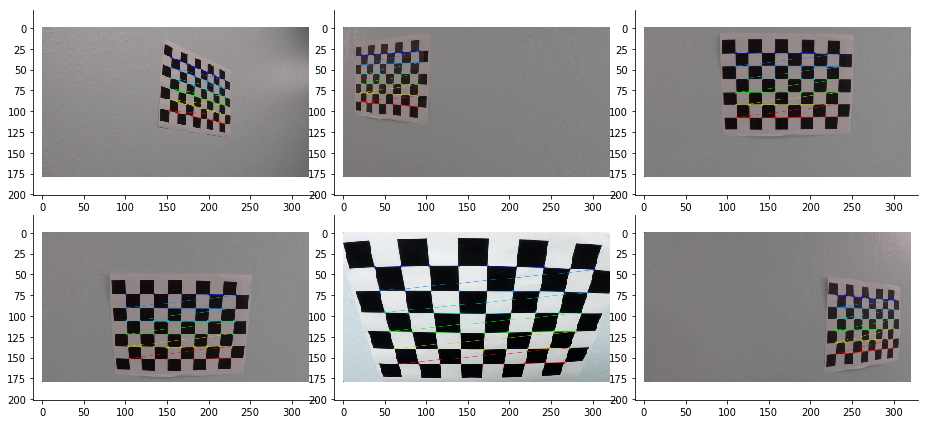

In [17]:
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(13,6), sharex=True, sharey=True)

for i, ax in enumerate(np.ravel(axes)):
    ax.imshow(corner_imgs[i])
    
plt.tight_layout()
sns.despine()

lets get original image size to further work on getting camera parameters which created distortion.

In [18]:
image_size = test_gray.shape[::-1]
print(image_size)

(1280, 720)


the function `calibrateCamera()`
return values have the following meanings:

- ret: The re-projection error
- mtx: The estimated camera matrix
- dist: The estimated distortion coefficients
- rvecs: The estimated rotation vectors for each input pattern
- tvecs: The estimation translation vectors for each input pattern

By passing the corner coordinates, the actual (distored) image coordinates and the size of the images system, we can obtain the calibration parameters.

In [20]:
results = cv2.calibrateCamera(obj_points, img_points, image_size, cameraMatrix= None,
                             distCoeffs = None)
ret, mtx, dist, rvecs, tvecs = results

In [21]:
ret

0.9231135540074413

In [22]:
test_undist = cv2.undistort(test_img, mtx, dist, None, mtx)

Result after undistortion:

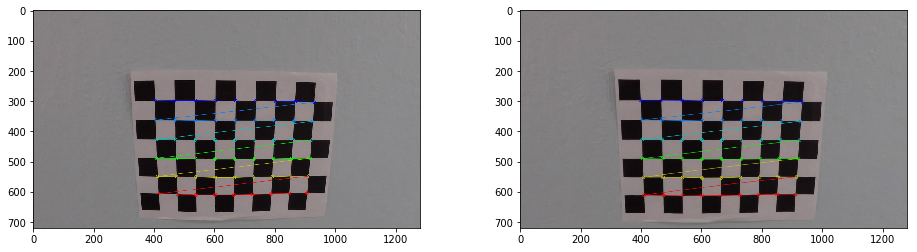

In [23]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].imshow(test_img)
axes[1].imshow(test_undist)

`cv2.getOptimalNewCameraMatrix()` which takes a tuning parameter alpha determining how much of the original image should be represented in the undistorted image. When set to 1, every source image is kept at the cost of an addition of black border pixels where no information existed in the first place

In [25]:
alpha=1
refined_mtx, ROI = cv2.getOptimalNewCameraMatrix(mtx, dist, image_size, alpha, image_size)

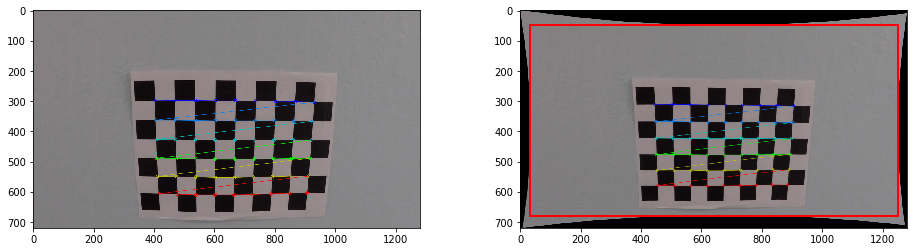

In [29]:
test_undist = cv2.undistort(test_img, mtx, dist, None, refined_mtx)
draw_rect = patches.Rectangle(xy=ROI[0:2], width=ROI[2], height=ROI[3], 
                              linewidth=2, edgecolor='r', fill=False)

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].imshow(test_img)
axes[1].imshow(test_undist)
axes[1].add_patch(draw_rect)

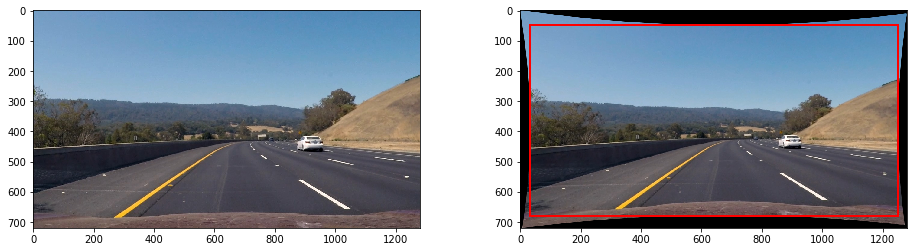

In [34]:
test_img = cv2.imread(os.path.join('..', 'test_images', 'test3.jpg'))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

test_undist = cv2.undistort(test_img, mtx, dist, None, refined_mtx)
draw_rect = patches.Rectangle(xy=ROI[0:2], width=ROI[2], height=ROI[3], 
                              linewidth=2, edgecolor='r', fill=False)

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].imshow(test_img)
axes[1].imshow(test_undist)
axes[1].add_patch(draw_rect)